In [ ]:
## Import required Libraries

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


In [4]:
## Import emotion dataset

In [5]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.10.0


In [6]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [7]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [8]:
## Divide data into Train, Validation and Test

In [9]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [10]:
## Get the tweet data and respective labels

In [11]:
def get_tweet_data(dataset):
    tweets=[x['text'] for x in dataset]
    labels=[x['label'] for x in dataset]
    return tweets, labels
    

In [12]:
tweets,labels=get_tweet_data(train)


In [13]:
## Tokenizer

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [16]:
lengths=[len(t.split(' '))for t in tweets]

In [18]:
## Histogram to check the lengths of the tweets

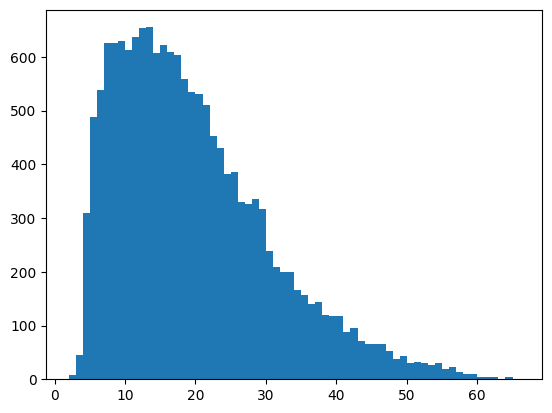

In [19]:
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [20]:
maxlen=50

In [21]:
## Padding and Truncating the data to have a same saize input

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [23]:
def get_sequences(tokenizer,tweets):
    sequences=tokenizer.texts_to_sequences(tweets)
    padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
    return padded

In [26]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
## Prepare Labels

In [27]:
classes = set (labels)

In [29]:
## Display all unique classes (emotions)

In [30]:
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [31]:
class_to_index=dict((c,i)for i,c in enumerate(classes))

In [32]:
class_to_index

{'anger': 0, 'sadness': 1, 'fear': 2, 'joy': 3, 'surprise': 4, 'love': 5}

In [33]:
index_to_class=dict((v,k)for k,v in class_to_index.items())

In [34]:
index_to_class

{0: 'anger', 1: 'sadness', 2: 'fear', 3: 'joy', 4: 'surprise', 5: 'love'}

In [35]:
name_to_ids=lambda labels:np.array([class_to_index.get(x)for x in labels])

In [36]:
train_labels=name_to_ids(labels)

In [37]:
## Create NN model

In [38]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
    
])
model.compile(
loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [41]:
## Train the model 

In [42]:
val_tweets,val_labels=get_tweet_data(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=name_to_ids(val_labels)

In [43]:
h=model.fit(
padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
        
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 31s 47ms/step - loss: 1.3339 - accuracy: 0.4479 - val_loss: 0.8499 - val_accuracy: 0.6885
Epoch 2/20
500/500 [==============================] - 18s 37ms/step - loss: 0.5814 - accuracy: 0.7983 - val_loss: 0.5459 - val_accuracy: 0.8155
Epoch 3/20
500/500 [==============================] - 19s 39ms/step - loss: 0.3419 - accuracy: 0.8852 - val_loss: 0.4789 - val_accuracy: 0.8415
Epoch 4/20
500/500 [==============================] - 20s 39ms/step - loss: 0.2598 - accuracy: 0.9088 - val_loss: 0.4597 - val_accuracy: 0.8505
Epoch 5/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1843 - accuracy: 0.9379 - val_loss: 0.4395 - val_accuracy: 0.8660
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 0.1484 - accuracy: 0.9522 - val_loss: 0.4616 - val_accuracy: 0.8680
Epoch 7/20
500/500 [==============================] - 19s 39ms/step - loss: 0.1244 - accuracy: 0.9621 - val_loss: 0.4383 - val_accuracy:

In [ ]:
## Show Training History

In [44]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

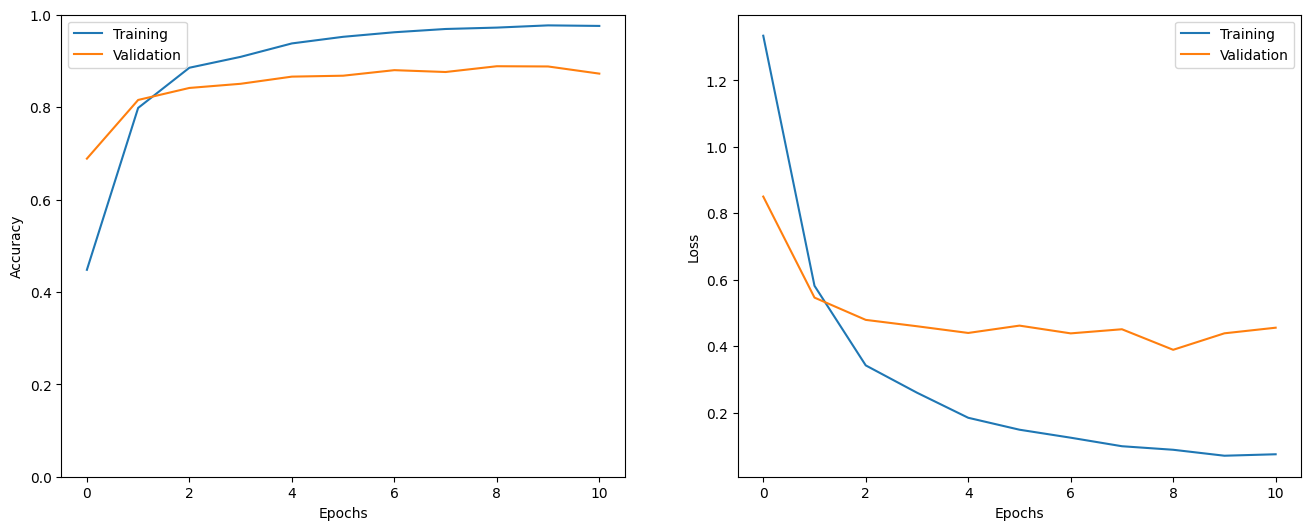

In [45]:
show_history(h)

In [46]:
## Predict the emotion

In [47]:
test_tweets,test_labels=get_tweet_data(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=name_to_ids(test_labels)

In [48]:
i=random.randint(0,len(test_labels)-1)
print ('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

Sentence: i feel like a may have mislead the very gracious readers of this blog
Emotion: joy


In [49]:
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('predicted Emotion:',pred_class)

1/1 [==============================] - 2s 2s/step
predicted Emotion: joy
